In [111]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import random
# import pyspark
# from pyspark.sql import SparkSession

import warnings
warnings.filterwarnings("ignore")

In [112]:
random_seed = 33
np.random.seed(random_seed)

### Read JSON from URL

In [113]:
def read_json_sampling(url, chunk_size, sample_size, random_state=None):
    """
    Reads a JSON file in chunks, samples from each chunk, and returns a combined sample.

    Args:
        url (str): JSON file url
        chunk_size (int): Number of rows to read in each chunk.
        sample_size (int): Total number of rows to sample.
        random_state (int, optional): Seed for random sampling. Defaults to None.

    Returns:
        pd.DataFrame: A DataFrame containing the sampled rows.
    """
    if random_state is not None:
        random.seed(random_state)

    sampled_chunks = []
    total_rows = 0

    for chunk in pd.read_json(url, lines=True, chunksize=chunk_size):
       
        chunk_sample_size = min(sample_size - total_rows, len(chunk))
        if chunk_sample_size > 0:
            sampled_chunk = chunk.sample(n=chunk_sample_size, random_state=random_state)
            sampled_chunks.append(sampled_chunk)
            total_rows += chunk_sample_size
        if total_rows >= sample_size:
            break

    return pd.concat(sampled_chunks, ignore_index=True)

#### Json from Local

In [114]:
url_reviews = '../data/raw/Appliances.jsonl.gz'
url_meta= '../data/raw/meta_Appliances.jsonl.gz'

#### Json from URL

In [115]:
# # Appliances
# url_reviews = 'https://mcauleylab.ucsd.edu:8443/public_datasets/data/amazon_2023/raw/review_categories/Appliances.jsonl.gz'
# url_meta = 'https://mcauleylab.ucsd.edu:8443/public_datasets/data/amazon_2023/raw/meta_categories/meta_Appliances.jsonl.gz'

In [116]:
# df_meta = read_json_sampling(url_meta, 10000, 2000000, 33)
# df_ratings = read_json_sampling(url_reviews, 10000, 2000000, 33)

In [117]:
# Try- For resetting display 
pd.options.display.max_colwidth = 50

### Dummy Test: Override auto load with manual dummy file test

In [118]:
dummy_ratings = ('../data/raw/dummy_ratings.jsonl.gz')
dummy_meta = ('../data/raw/dummy_meta.jsonl.gz') 

In [119]:
df_meta = pd.read_json(dummy_meta)
df_ratings = pd.read_json(dummy_ratings)

In [120]:
df_meta.reset_index(drop=True, inplace=True)
df_ratings.reset_index(drop=True, inplace=True)

In [121]:
df_ratings.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,I am AMAZED to See Bad Reviews.,I came here to post a review because these are...,[],B00LGEKOMS,B07RNJY499,AEDTXOC3YW6O7P2UPM22VNNRF77A,2020-10-16 20:26:21.427,0,True
1,5,Works well,Happy with product,[],B01DP1IWKU,B092LLM7H3,AE6DFDMIJAVW57EVMRJH2M2X6ACA,2021-12-01 22:22:40.165,1,True
2,4,Four Stars,This works well.,[],B000DLB2FI,B000DLB2FI,AEVGR67KN3CT4TO5D6HO3WNZGRPA,2015-02-27 12:51:16.000,0,True
3,5,Five Stars,GREAT,[],B0001IRRLQ,B0BHNSLKNZ,AFLEUJNQJQOYOYDUJ2PSZ4O2TUJA,2015-11-07 03:54:08.000,0,True
4,5,Savings,"Exelent, save on coffee, water, no waste, e...",[],B00LGEKOMS,B07RNJY499,AEOVCZC77QZJQPBIAIKCFV7AS7PA,2017-10-16 22:46:40.529,0,True


## DATA CLEANING

#### Cleaning META

In [122]:
# Verify shape
df_meta.shape

(30, 16)

In [123]:
# Verify dtypes
df_meta.dtypes

main_category       object
title               object
average_rating     float64
rating_number        int64
features            object
description         object
price              float64
images              object
videos              object
store               object
categories          object
details             object
parent_asin         object
bought_together    float64
subtitle           float64
author             float64
dtype: object

In [124]:
# Verify columns 
df_meta.columns

Index(['main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'images', 'videos', 'store', 'categories',
       'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
      dtype='object')

<div class="alert alert-block alert-warning">
[Decision Block] Decide which columns to drop
</div>

In [125]:
# Drop columns that are not needed in the analysis

# Images and videos won't be utilized in the analysis
# Price is not needed for this analysis so we drop it for now. 
# Average_rating and rating number can be dropped as well 


cols_to_drop = [ 'average_rating', 'rating_number', 'price', 'images', 'videos', 'bought_together', 'subtitle', 'author']
df_meta.drop( cols_to_drop, axis=1, inplace=True )


In [126]:
# Verify: After dropping columns. df_meta types and counts
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   main_category  30 non-null     object
 1   title          30 non-null     object
 2   features       30 non-null     object
 3   description    30 non-null     object
 4   store          30 non-null     object
 5   categories     30 non-null     object
 6   details        30 non-null     object
 7   parent_asin    30 non-null     object
dtypes: object(8)
memory usage: 2.0+ KB


In [127]:
# Dealing with empty lists in columns:

# Get % of empty lists [] in cols of interest.
# Delete column if it exceeds threshold values -> separate this functionality

threshold = 0.25
cols_of_interest = ['features', 'description', 'categories'] #-- Exclude description as it can be used in feature groups down the line.

for col in cols_of_interest:

    pct = sum(~df_meta[col].astype(bool)) / len(df_meta)
    print(f'Empty [{col}] : {100*pct:.2f}%')
    
    # # Drop column if it exceeds threshold value for empty list
    # if pct >= threshold:
    #     df_meta.drop(col, axis=1, inplace=True)


Empty [features] : 20.00%
Empty [description] : 43.33%
Empty [categories] : 6.67%


In [128]:
# Verify: No null columns in meta
df_meta.isna().sum()

main_category    0
title            0
features         0
description      0
store            0
categories       0
details          0
parent_asin      0
dtype: int64

In [129]:
# Fill null values, as needed. 
df_meta.store.fillna('Undescribed', inplace=True)
df_meta.main_category.fillna('Uncategorized', inplace=True)

In [130]:
# UT: No null columns in meta
df_meta.isna().sum()

main_category    0
title            0
features         0
description      0
store            0
categories       0
details          0
parent_asin      0
dtype: int64

In [131]:
# Verify shape after cleaning steps
df_meta.shape

(30, 8)

#### Cleaning RATINGS

In [132]:
# Verify shape
df_ratings.shape

(5547, 10)

In [133]:
# Verify dtypes
df_ratings.dtypes

rating                        int64
title                        object
text                         object
images                       object
asin                         object
parent_asin                  object
user_id                      object
timestamp            datetime64[ns]
helpful_vote                  int64
verified_purchase              bool
dtype: object

In [134]:
# Verify dataset
df_ratings.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,I am AMAZED to See Bad Reviews.,I came here to post a review because these are...,[],B00LGEKOMS,B07RNJY499,AEDTXOC3YW6O7P2UPM22VNNRF77A,2020-10-16 20:26:21.427,0,True
1,5,Works well,Happy with product,[],B01DP1IWKU,B092LLM7H3,AE6DFDMIJAVW57EVMRJH2M2X6ACA,2021-12-01 22:22:40.165,1,True
2,4,Four Stars,This works well.,[],B000DLB2FI,B000DLB2FI,AEVGR67KN3CT4TO5D6HO3WNZGRPA,2015-02-27 12:51:16.000,0,True
3,5,Five Stars,GREAT,[],B0001IRRLQ,B0BHNSLKNZ,AFLEUJNQJQOYOYDUJ2PSZ4O2TUJA,2015-11-07 03:54:08.000,0,True
4,5,Savings,"Exelent, save on coffee, water, no waste, e...",[],B00LGEKOMS,B07RNJY499,AEOVCZC77QZJQPBIAIKCFV7AS7PA,2017-10-16 22:46:40.529,0,True


In [135]:
# Drop columns that are not needed in the analysis
cols_to_drop = ['title', 'text', 'images', 'helpful_vote', 'timestamp', 'verified_purchase' ]

# Drop columns
df_ratings.drop(cols_to_drop, axis=1, inplace=True)

In [136]:
# UT: No null columns in df_ratings
df_ratings.isna().sum()

rating         0
asin           0
parent_asin    0
user_id        0
dtype: int64

## EDA

#### Merging meta and reviews

In [137]:
# Merge metadata and reviews dataset
df = pd.merge(df_meta, df_ratings, how='left', on='parent_asin')

In [138]:
# Verify shape
df.shape

(5567, 11)

In [139]:
# Verify null columns
df.isna().sum()

main_category     0
title             0
features          0
description       0
store             0
categories        0
details           0
parent_asin       0
rating           20
asin             20
user_id          20
dtype: int64

##### Unrated items

#### Summary Statistics

In [140]:
# Summary Stats - Info on counts

# n_products_pasin = df.parent_asin.nunique()

n_products = df.asin.nunique()
n_titles = df.title.nunique()
n_ratings = len(df.rating)
n_users = df.user_id.nunique()

# print(f'Total unique parent products: {n_products_pasin}')
print(f'Total unique products: {n_products}')
print(f'Total unique product name: {n_titles}')
print(f'Total ratings: {n_ratings}')
print(f'Total unique users: {n_users}')

Total unique products: 27
Total unique product name: 30
Total ratings: 5567
Total unique users: 5363


> Notes: 
> - [asin] represents a variant of a parent product. 
> - Every ***RATED*** product in the ratings dataset has an [asin]
> - A product should be evaluated using [asin], not its parent [parent_asin]\
> ***Reference: https://webservices.amazon.com/paapi5/documentation/parent-asin.html***

In [141]:
# Summary Statistics - Averages ``
avg_rating_p_product = round(n_ratings/n_products, 2)
avg_rating_p_user = round(n_ratings/n_users, 2)

print(f'Average no. of ratings per product: {avg_rating_p_product}')
print(f'Average no. of ratings per user: {avg_rating_p_user}')

Average no. of ratings per product: 206.19
Average no. of ratings per user: 1.04


In [142]:
# Summary statistics -  describe()
df.select_dtypes(include = 'number').describe()

,rating
count,5547.000000
mean,4.416261
std,1.160401
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


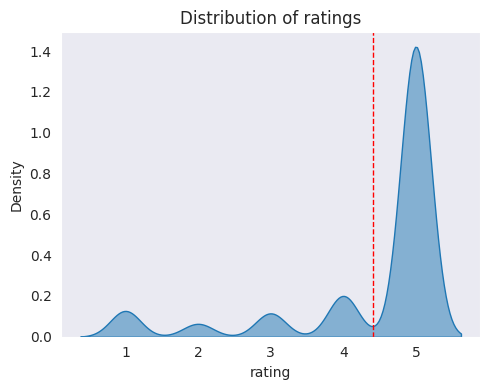

In [143]:
# Distribution of ratings
sns.set_style('dark', {'axes.grid':False})
plt.figure(figsize=(5,4))

# _ = sns.histplot(data=df, x='rating', color='teal', bins=5, kde=True)
_ = sns.kdeplot(data=df, x='rating', fill=True, alpha=0.5)
_.set_title('Distribution of ratings')
plt.axvline(x=df['rating'].mean(), ls='--', linewidth=1, color='red')
plt.tight_layout()
plt.show()

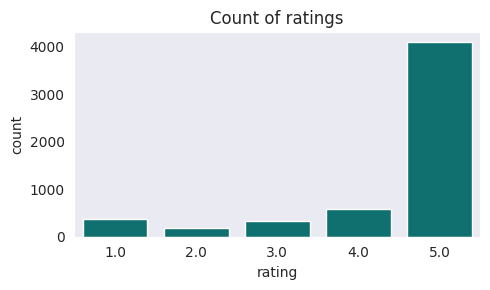

In [144]:
# Count Ratings
plt.figure(figsize=(5,3))
_ = sns.countplot(data=df, x='rating', color='teal')
_.set_title('Count of ratings')
plt.tight_layout()
plt.show()

#### Top Main Categories

<div class="alert alert-block alert-warning">
[Decision block] Set the number of K
</div>

In [145]:
# Set n results to extract and display
k = 10

In [146]:
# Extract and show Top K Categories
vc_categories = pd.DataFrame(df['main_category'].value_counts()).reset_index()
vc_categories[0:k]


,main_category,count
0,Amazon Home,4416
1,Appliances,586
2,Grocery,545
3,Tools & Home Improvement,18
4,Industrial & Scientific,1
5,All Beauty,1


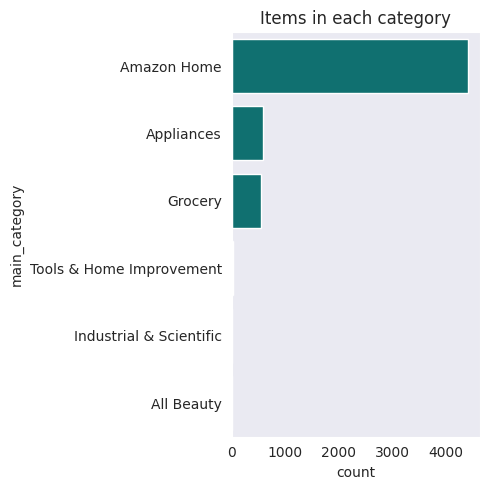

In [147]:
# Plot categories
sns.set_style('dark', {'axes.grid':False})
plt.figure(figsize=(5,5))

_ = sns.barplot(data=vc_categories, y='main_category', x='count', color='teal')
_.set_title('Items in each category')
plt.tight_layout()
plt.show()

#### Extracting Subcategory - For granularity

In [148]:
# Extract the last category in the list values in [categories] 
df_meta['subcategory'] = df_meta['categories'].apply(lambda x: x[-1] if len(x) else None)

# If [categories] is empty, assign value from [main_category]
df_meta.subcategory.fillna(df_meta['main_category'], inplace=True)

In [149]:
# Checkpoint: No null values in subcategory
assert df_meta.subcategory.isna().sum() == 0, "There are null values in subcategory column."

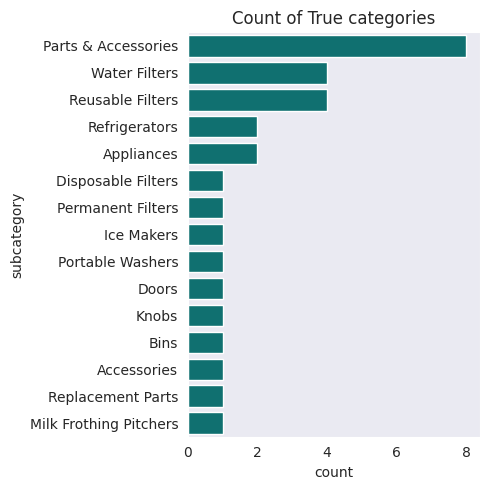

In [150]:
# Plot subcategories
vc_subcategory = df_meta.subcategory.value_counts().reset_index()

plt.figure(figsize=(5,5))
_ = sns.barplot(data=vc_subcategory, y='subcategory', x='count', color='teal')
_.set_title('Count of True categories')
plt.tight_layout()
plt.show()

In [151]:
# Drop the categories column with dictionary values
df_meta.drop('categories', axis=1, inplace=True)

### Content-Based Filtering

#### Recommending Top Rated Items - A solution to Cold-Start problem

In [152]:
# Re-merge updated meta with ratings
df = df_ratings.merge(df_meta, how='left', on='parent_asin')

In [153]:
# Verify
df.shape

(5547, 11)

#### Top K Frequently rated

In [154]:
# Top K Frequently Rated
df_most_rated = pd.DataFrame(df[['parent_asin', 'title', 'main_category', 'subcategory']].value_counts()[0:k]).reset_index()

In [155]:
# Show Top K Frequently Rated
df_most_rated

,parent_asin,title,main_category,subcategory,count
0,B07RNJY499,iPartPlusMore Reusable Coffee Filters Compatib...,Amazon Home,Reusable Filters,1329
1,B0B3DB5HTC,12 Pack Keurig Filter Replacement by K&J - Com...,Amazon Home,Disposable Filters,1220
2,B000DLB2FI,Keurig My K-Cup Reusable Coffee Filter - Old M...,Amazon Home,Reusable Filters,681
3,B0BHNSLKNZ,"Cuisinart Replacement Water Filters, 2-Pack",Amazon Home,Permanent Filters,605
4,B07P3Y8JWY,Disposable Paper Coffee Filters 600 count - Co...,Amazon Home,Reusable Filters,577
5,B0045LLC7K,Frigidaire WF3CB Puresource3 Refrigerator Wate...,Appliances,Water Filters,574
6,B092LLM7H3,Reusable coffee pods for Coffee Makers (4 PACK...,Grocery,Reusable Filters,545
7,B01IAFNZGC,EXCELPURE 5231JA2006A Replacement for LG LT600...,Tools & Home Improvement,Water Filters,10
8,B0BJ2CJTB5,Mini Washing Machine Portable Turbine Washer w...,Appliances,Portable Washers,5
9,B01DMRHDZ2,ClimaTek Gas Oven Range Stove Ignitor Igniter ...,Industrial & Scientific,Parts & Accessories,1


#### Top K Highly Rated

##### ---Option A: Sorting By Mean Ratings and Count

In [156]:
# Sort ratings then count. Not the ideal way to calculate ratings.
prod_stats = df.groupby(['parent_asin', 'title', 'main_category', 'subcategory'])['rating']\
        .agg(['count', 'mean'])\
        .reset_index()\
        .sort_values(['mean', 'count'], ascending=False)

In [157]:
# Show Top K highest ave ratings and by count
prod_stats.head(k)

,parent_asin,title,main_category,subcategory,count,mean
3,B01IAFNZGC,EXCELPURE 5231JA2006A Replacement for LG LT600...,Tools & Home Improvement,Water Filters,10,5.000000
7,B0B3DB5HTC,12 Pack Keurig Filter Replacement by K&J - Com...,Amazon Home,Disposable Filters,1220,4.890984
6,B092LLM7H3,Reusable coffee pods for Coffee Makers (4 PACK...,Grocery,Reusable Filters,545,4.502752
8,B0BHNSLKNZ,"Cuisinart Replacement Water Filters, 2-Pack",Amazon Home,Permanent Filters,605,4.419835
1,B0045LLC7K,Frigidaire WF3CB Puresource3 Refrigerator Wate...,Appliances,Water Filters,574,4.397213
5,B07RNJY499,iPartPlusMore Reusable Coffee Filters Compatib...,Amazon Home,Reusable Filters,1329,4.263356
4,B07P3Y8JWY,Disposable Paper Coffee Filters 600 count - Co...,Amazon Home,Reusable Filters,577,4.235702
0,B000DLB2FI,Keurig My K-Cup Reusable Coffee Filter - Old M...,Amazon Home,Reusable Filters,681,3.979442
9,B0BJ2CJTB5,Mini Washing Machine Portable Turbine Washer w...,Appliances,Portable Washers,5,1.400000
2,B01DMRHDZ2,ClimaTek Gas Oven Range Stove Ignitor Igniter ...,Industrial & Scientific,Parts & Accessories,1,1.000000


> Not very reliable. Consider Weighted Avg vs Bayesian Avg. 

#### ---Option B: Calculating Bayesian Average of Ratings

In [158]:
# c_confidence:  typical dataset size or average number(or count) of ratings for a given product
c_confidence = prod_stats['count'].mean()

# m_priori :  mean rating across all products
m_priori = prod_stats['mean'].mean()

In [159]:
# Show confidence and priori values
print(f'Confidence : {c_confidence}')
print(f'Priori: {m_priori}')

Confidence : 554.7
Priori: 3.808928296460555


In [160]:
def bayesian_average(l_ratings):
    """
    Calculate the Bayesian average rating for a product.
    Args:
        l_ratings (pd.Series): Series of ratings for a product.
    Returns:
        float: Bayesian average rating.
    """
    bayes_avg =  ( (c_confidence * m_priori) + l_ratings.sum() )/ ( c_confidence + l_ratings.count())
    return round(bayes_avg, 3)

In [161]:
# Get the bayesian average in prod_stats
bayesian_ratings = df.groupby(['asin', 'main_category', 'subcategory', 'title'])['rating'].agg(bayesian_average).reset_index().sort_values('rating', ascending=False)

In [162]:
# Show top K bayesian ratings
bayesian_ratings[0:k]

,asin,main_category,subcategory,title,rating
14,B01DLEL4EM,Amazon Home,Disposable Filters,12 Pack Keurig Filter Replacement by K&J - Com...,4.485
17,B01GAGM62M,Amazon Home,Disposable Filters,12 Pack Keurig Filter Replacement by K&J - Com...,4.185
16,B01DP1IWKU,Grocery,Reusable Filters,Reusable coffee pods for Coffee Makers (4 PACK...,4.149
8,B0045LLC7K,Appliances,Water Filters,Frigidaire WF3CB Puresource3 Refrigerator Wate...,4.108
11,B00LGEKOMS,Amazon Home,Reusable Filters,iPartPlusMore Reusable Coffee Filters Compatib...,4.036
1,B0001IRRLG,Amazon Home,Permanent Filters,"Cuisinart Replacement Water Filters, 2-Pack",4.011
10,B00BUFJBQS,Amazon Home,Reusable Filters,Disposable Paper Coffee Filters 600 count - Co...,4.009
13,B01AUBYMK2,Amazon Home,Reusable Filters,iPartPlusMore Reusable Coffee Filters Compatib...,3.963
6,B000TETMVK,Amazon Home,Permanent Filters,"Cuisinart Replacement Water Filters, 2-Pack",3.950
19,B06X9RFT2J,Amazon Home,Reusable Filters,iPartPlusMore Reusable Coffee Filters Compatib...,3.946


#### Extracting the Maker 

The brand, manufacturer or main distributor of a product

In [163]:
# Verify
df_meta.isna().sum()

main_category    0
title            0
features         0
description      0
store            0
details          0
parent_asin      0
subcategory      0
dtype: int64

In [164]:
# Create new column [maker] and assign/extract brand or manufacturer from {details} 
df_meta['maker'] = df_meta['details'].apply(lambda x: x.get('Brand') if not x else x.get('Manufacturer'))

# If [details] have no dict{} values, assign the [store] value
df_meta.maker.fillna(df_meta['store'], inplace=True)

In [165]:
# Checkpoint: No null values in maker
assert df_meta.maker.isna().sum() == 0, "There are null values in maker column."

In [166]:
# Verify maker column
df_meta[['main_category', 'title', 'store', 'maker']].head(2)

,main_category,title,store,maker
0,Amazon Home,"Cuisinart Replacement Water Filters, 2-Pack",Cuisinart,Cuisinart
1,Amazon Home,12 Pack Keurig Filter Replacement by K&J - Com...,K&J,K&J


In [167]:
# Drop categories and details - for now
df_meta.drop('details', axis=1, inplace=True)

#### Analyze Word counts

Analyze the word counts in title, description, store and details.


In [168]:
# Transform [description] and features list to a stream of str 
df_meta['description'] = df_meta['description'].apply(lambda x: ' '.join(x))
df_meta['features'] = df_meta['features'].apply(lambda x: ' '.join(x))

In [169]:
# cols_object = df_meta.select_dtypes(include='object').columns
cols_object = ['title', 'description', 'features']

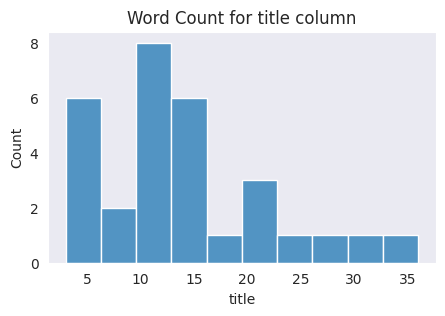

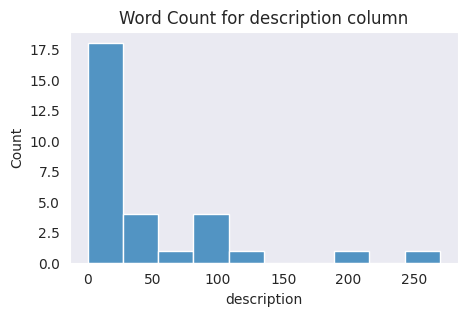

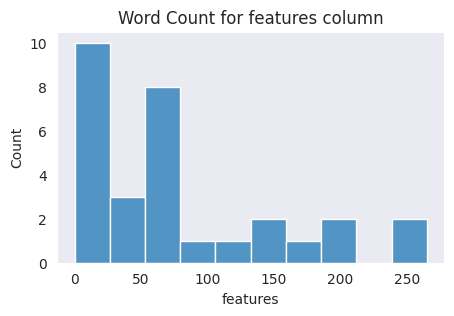

In [170]:
# Count words for columns of interests.
for col in cols_object:

    word_ct = df_meta[col].str.split().str.len()

    sns.set_style('dark')
    plt.figure(figsize=(5,3))

    hist = sns.histplot(x=word_ct, bins=10)
    hist.set_title(f'Word Count for {col} column')
    plt.show()

#### Distribution of ratings - For noise reduction 

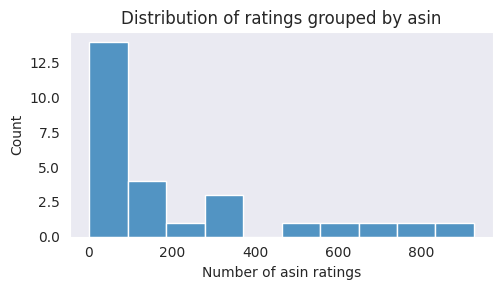

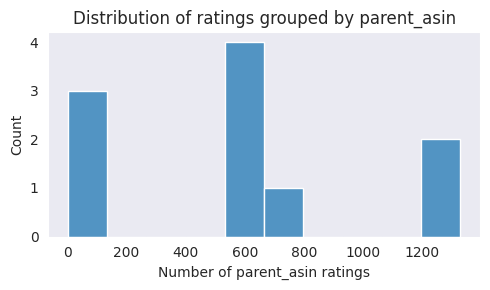

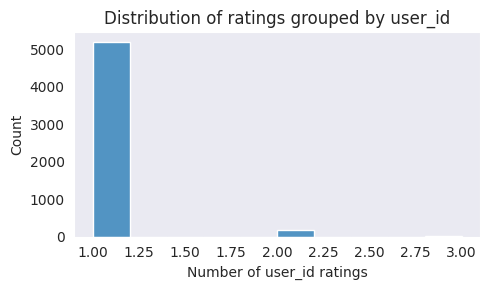

In [171]:
# Check the distribution of ratings to help decide the threshold to keep - What's the min no. of ratings for a product to be recommended to user? 

cols_of_interest = ['asin', 'parent_asin', 'user_id']
for col in cols_of_interest:
    plt.figure(figsize=(5,3))
    df_vc = df[col].value_counts(ascending=False).reset_index()
    
    sns.histplot(data=df_vc, x='count', bins=10)
    plt.xlabel(f'Number of {col} ratings')
    plt.title(f'Distribution of ratings grouped by {col}')
    plt.tight_layout()
    plt.show()

## PRE-PROCESSING

### Feature Engineering

> Note: For feature group [parent_asin] was used because products that have not been reviewed does not have a corresponding [asin]

In [172]:
# Verify
df_meta.head()

,main_category,title,features,description,store,parent_asin,subcategory,maker
0,Amazon Home,"Cuisinart Replacement Water Filters, 2-Pack",Made of nonwoven polyester and activated charc...,Product Description Make sure you're brewing t...,Cuisinart,B0BHNSLKNZ,Permanent Filters,Cuisinart
1,Amazon Home,12 Pack Keurig Filter Replacement by K&J - Com...,PERFECT FIT - These Keurig-compatible replacem...,,K&J,B0B3DB5HTC,Disposable Filters,K&J
2,Grocery,Reusable coffee pods for Coffee Makers (4 PACK...,,,Delibru,B092LLM7H3,Reusable Filters,Delibru
3,Amazon Home,Disposable Paper Coffee Filters 600 count - Co...,"Compatible with Solofill, Solo Filters, EZ-Cup...",,SIMPLECUPS,B07P3Y8JWY,Reusable Filters,Simple Cups
4,Amazon Home,iPartPlusMore Reusable Coffee Filters Compatib...,ECO-ALTERNATIVE COFFEE FILTERS: Save up to 80%...,,iPartsPlusMore,B07RNJY499,Reusable Filters,iPartsPlusMore


<div class="alert alert-block alert-warning">
[Decision Block] Decide which columns should be used as tags or combined in a feature group.
</div>

In [173]:
# Select the features to be used for NLP

selected_features = ['parent_asin',  'main_category', 'subcategory', 'maker', 'title']
# selected_features = ['parent_asin', 'title', 'store', 'details']
# --Note: removed [store][details] due to resource issues - Unable to allocate 31.4 GiB for an array with shape (4220106037,) and data type int64.

# Concatenate the selected features into a single string column
df_meta['feature_group'] = df_meta[selected_features].agg(' '.join, axis=1)

In [174]:
# Verify the new column
df_meta.head(2)

,main_category,title,features,description,store,parent_asin,subcategory,maker,feature_group
0,Amazon Home,"Cuisinart Replacement Water Filters, 2-Pack",Made of nonwoven polyester and activated charc...,Product Description Make sure you're brewing t...,Cuisinart,B0BHNSLKNZ,Permanent Filters,Cuisinart,B0BHNSLKNZ Amazon Home Permanent Filters Cuisi...
1,Amazon Home,12 Pack Keurig Filter Replacement by K&J - Com...,PERFECT FIT - These Keurig-compatible replacem...,,K&J,B0B3DB5HTC,Disposable Filters,K&J,B0B3DB5HTC Amazon Home Disposable Filters K&J ...


### Find Similar Products

In [175]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /home/edu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/edu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [176]:
# NLP Objects and parameters
wnl = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

#### NLP UDFs

In [177]:
def preprocess_text(text):
    """
    Preprocesses the input text by removing special characters, converting to lowercase,
    removing stop words, and applying stemming or lemmatization.

    Args:
        text (str): Input text to preprocess.
    Returns:
        str: Preprocessed text.
    """
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
        
    return text

In [178]:
def tokenizer(txt):
    """
    Tokenizes the input text by removing stop words and applying stemming or lemmatization.
    Flags to indicate if tokenization is set to True. 

    Args:
        txt (str): Input text to tokenize.
    Returns:
        list: List of tokens.
    """

    word_tokens = nltk.word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]

    return filtered_sentence

In [179]:
def lemmatizer(txt):
    """
    Lemmatizes the input text by removing stop words and applying stemming or lemmatization.
    Flags to indicate if lemmatization is set to True.
    Args:
        txt (str): Input text to lemmatize.
    Returns:
        str: Lemmatized text.
    """
    
    filtered_text = [wnl.lemmatize(text) for text in txt]
    
    return ' '.join(filtered_text)

#### Apply the NLP Functions to pre-process, tokenize, lemmatize texts

In [180]:
# Apply preprocessing to the feature group
df_meta['feature_group'] = df_meta['feature_group'].apply(preprocess_text)

In [181]:
# Apply custom tokenizer to feature_group column# Apply custom tokenizer to feature_group column
df_meta['feature_group'] = df_meta['feature_group'].apply(lambda x: tokenizer(x))

In [182]:
# Apply lemmatizer to feature_group column
df_meta['feature_group'] = df_meta['feature_group'].apply(lambda x: lemmatizer(x))

#### Vectorize the [feature_group]

In [183]:
# Create a csr matrix
vectorizer = TfidfVectorizer(analyzer='word',stop_words='english')
feature_vectors = vectorizer.fit_transform(df_meta['feature_group'].values)

In [184]:
# Verify/Preview the sparse martrix
print(feature_vectors)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 447 stored elements and shape (30, 282)>
  Coords	Values
  (0, 66)	0.3257230282117321
  (0, 31)	0.1855857897294682
  (0, 150)	0.12969818423540308
  (0, 212)	0.3257230282117321
  (0, 128)	0.33942131523625463
  (0, 100)	0.6514460564234642
  (0, 227)	0.19475975760687753
  (0, 268)	0.23006448114557898
  (0, 9)	0.3257230282117321
  (1, 31)	0.1497597127927342
  (1, 150)	0.10466083016995628
  (1, 128)	0.27389833434775257
  (1, 227)	0.1571627084450055
  (1, 62)	0.2628444086482938
  (1, 111)	0.23435502233757408
  (1, 168)	0.5256888172965876
  (1, 2)	0.23435502233757408
  (1, 210)	0.1856520947557252
  (1, 166)	0.39692528074916616
  (1, 91)	0.17482093276462413
  (1, 87)	0.17482093276462413
  (1, 181)	0.1856520947557252
  (1, 5)	0.23435502233757408
  (1, 206)	0.2628444086482938
  (2, 128)	0.1575059806162777
  :	:
  (28, 215)	0.45568775204979983
  (28, 80)	0.3037918346998666
  (28, 209)	0.1518959173499333
  (28, 123)	0.3037918346998666
 

In [185]:
# Verify the shape of the feature vectors
print("Shape of feature vectors:", feature_vectors.shape)

Shape of feature vectors: (30, 282)


#### Calculate Cosine Similarity

In [186]:
# Calculate cosine similarity
similarity = cosine_similarity(feature_vectors)
similarity.shape

(30, 30)

In [187]:
# Set display option 
pd.options.display.max_colwidth = 1000

#### Option A: Similar items using ASIN (product key)

In [188]:
def get_product_data(query:str , data_df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    UDF: Gets the product data by matching query with the column of interest.
    Args:
        query (str): Search query
        data_df (pd.DataFrame): DataFrame to search in
        col (str): Column to search in
    Returns:
        pd.DataFrame: DataFrame containing the search results
    """
    
    # Search [col] using exact query
    l_data = data_df[data_df[col] == query] 

    # If exact match or single row returned 
    if len(l_data) == 1:                    
        print('Exact product match used in query.')
    
    # If not exact found in [col], refine search...
    else:

        # Check in [title] if it contains the refined query (removed special characters and lower cased) 
        query = re.sub(r'[^a-zA-Z0-9\s]', '', query)
        l_data = data_df[data_df['title']\
                  .apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))\
                  .str.lower()
                  .str.contains(query.lower())\
                    ]

        # If refined query matches one or more product names
        if len(l_data) > 0:
            print('Found products with similar keywords.')

        else:            
            print('No products matched the keywords in query. Try again.')

    return l_data


In [189]:
def get_product_index(data_df: pd.DataFrame, query:str, col: str) -> int:
    """
    Get the index of the product in the DataFrame based on the query.
    Args:
        data_df (pd.DataFrame): DataFrame containing product data.
        query (str): Query string to search for.
        col (str): Column name to search in.
    Returns:
        int: Index of the product in the DataFrame.
    """

    product_index = data_df[data_df[col] == query].index
    return product_index[0] if len(product_index) > 0 else None

In [190]:
def search_similar_product(query: str, data_df: pd.DataFrame, cos_sim: np.array, k: int = 1) -> list:
    """
    Recommend similar products based on the query and cosine similarity.
    Args:
        query (str): Search query.
        data_df (pd.DataFrame): DataFrame containing product data.
        cos_sim (np.array): Cosine similarity matrix.
        k (int): Number of similar products to recommend. Defaults to 1.
    Returns:
        list: List of similar products with their IDs and titles.
    """

    l_prods = get_product_data(query, data_df, 'parent_asin')

    
    if len(l_prods) > 0:

        top_idx = l_prods.index[0]
        distances = sorted(list(enumerate(cos_sim[top_idx])), reverse=True, key=lambda x:x[1])

        # display(distances[0:k])
        similar_items = []

        # Assumptions: 
        #    l_prods length == 1: Exact product_name match or passed via pre-loaded drop_down list
        #    l_prods length >  1 : Generic keyword search returned multiple matches. Set begin idx to 0 and include the first item in the distances list.

        ret_begin_idx = 0

        if len(l_prods) == 1:  # exclude the first item in the distances list
            ret_begin_idx = 1
            k += 1
        
        # Iterate over distances
        for p_id in distances[ret_begin_idx:(k)]: 

            similar_items.append({'parent_asin': data_df.iloc[p_id[0]].parent_asin, 
                                 'main_category': data_df.iloc[p_id[0]].main_category, 
                                 'subcategory': data_df.iloc[p_id[0]].subcategory,
                                 'maker': data_df.iloc[p_id[0]].maker,
                                 'title': data_df.iloc[p_id[0]].title, 
                                 'similarity': p_id[1]})

    return similar_items

<div class="alert alert-block alert-warning">
[Input block] Select/specify a product ID [asin]
</div>

In [191]:
# Select/Specify a product ID (ideal) or name to search for

query = 'B000DLB2FI'
# query = 'Keurig My K-Cup Reusable Coffee Filter - Old Model'

In [192]:
# Verify
# lookup product in df_meta by searching for the product_asin or keywords in the title
_ = get_product_data(query, df_meta, 'parent_asin')

Exact product match used in query.


##### Recommend Similar Products

In [193]:
# Call fuction: search_similar_product
list_recos = search_similar_product(query, df_meta, similarity, k)

Exact product match used in query.


In [194]:
# Convert the Top N list to DataFrame
df_recos = pd.DataFrame(list_recos)

In [195]:
# Show Similar Products
df_recos

,parent_asin,main_category,subcategory,maker,title,similarity
0,B07P3Y8JWY,Amazon Home,Reusable Filters,Simple Cups,"Disposable Paper Coffee Filters 600 count - Compatible with Keurig, K-Cup machines & other Single Serve Coffee Brewer Reusable K Cups - Use Your Own Coffee & Make Your Own Pods - Works with All Brands",0.421959
1,B07RNJY499,Amazon Home,Reusable Filters,iPartsPlusMore,iPartPlusMore Reusable Coffee Filters Compatible with 1.0 and 2.0 Keurig Single Cup Coffee Maker - BPA-Free Stainless Steel Refillable K Cup Coffee Filter with Fine Mesh Screen (Pack of 4),0.406264
2,B0B3DB5HTC,Amazon Home,Disposable Filters,K&J,12 Pack Keurig Filter Replacement by K&J - Compatible with Keurig Coffee Machine (2.0 and older),0.341106
3,B092LLM7H3,Grocery,Reusable Filters,Delibru,Reusable coffee pods for Coffee Makers (4 PACK Black and Purple),0.338949
4,B0BHNSLKNZ,Amazon Home,Permanent Filters,Cuisinart,"Cuisinart Replacement Water Filters, 2-Pack",0.154537
5,B09YRPT4Q2,Amazon Home,Water Filters,BELVITA,"BELVITA ADQ747935 Water Filter Replacement,Compatible with LT1000P,LFXS26973S,LMXS28626S,LMXS30796S,LMXC23796S,Kenmore Elite 9980 ADQ74793501 MDJ64844601,3 Pack",0.118376
6,B0045LLC7K,Appliances,Water Filters,Frigidaire,"Frigidaire WF3CB Puresource3 Refrigerator Water Filter , White, 1 Count (Pack of 1)",0.100118
7,B01IAFNZGC,Tools & Home Improvement,Water Filters,EXCELPURE,"EXCELPURE 5231JA2006A Replacement for LG LT600P,5231JA2006B, Kenmore 46-9990, 5231JA2006F,R-9990, 5231JA2006E, LFX25975ST, LFX25960ST, EFF-6003A, LFX23961ST, SGF-LB60, Refrigerator Water Filter, 3PACK",0.079437
8,B0BC65XJLJ,Amazon Home,Water Filters,KASTORE F1,"W10295370A Water FiIter Cap Replacement, Compatible with EDR1RXD1 Refrigerator Water FiIter 1 46-9081, 46-9930 Water FiIter Cap Replacement 1, 3Packs",0.054844
9,B07S9DJ2S2,Amazon Home,Ice Makers,Amazon Renewed,"Frigidaire Portable Compact Maker, Counter Top Ice Making Machine, 26lb per day (Blue) (EFIC108-BLUE) (Renewed)",0.052436


#### Option B: Similar items using vectorized query

- Transform the query using the same vocabulary from the previous fit step on the corpus.
- Calculate the pairwise cosine similarities between each document in the corpus and the query.
- Sort them in descending order by score

In [196]:
def get_query_tfidf(tfidf_vectorizer: TfidfVectorizer, query:str) -> np.ndarray:
    """
    Get the TF-IDF vector for the query.
    Args:
        data_df (pd.DataFrame): DataFrame containing product data.
        query (str): Query string to search for.
        col (str): Column name to search in.
    Returns:
        np.ndarray: TF-IDF vector for the query.
    """
    
    formatted_query = preprocess_text(query) 
    formatted_query = tokenizer(formatted_query)
    formatted_query = lemmatizer(formatted_query)
    query_vector = tfidf_vectorizer.transform([formatted_query])
    
    return query_vector

In [197]:
def top_k(arr_cosim, k=1):
    """
    Get the indices of the top k elements in an array.
    Args:
        arr (np.ndarray): Input array.
        k (int): Number of top elements to retrieve. Defaults to 1.
    Returns:
        list: List of indices of the top k elements.
    """
    kth_largest = (k+1) * -1
    return np.argsort(arr_cosim)[:kth_largest:-1]

<div class="alert alert-block alert-warning">
[Input block] Input search query text, keywords, or description of the product you want to search for.
</div>

In [198]:
query = 'K-Cup Reusable Coffee Filter'
# query = 'Keurig My K-Cup Reusable Coffee Filter - Old Model'

##### Process query

In [199]:
# Get the tfidf vector for the query
query_tfidf = get_query_tfidf(vectorizer, query)

##### Calculate Similarity

In [200]:
# Compute cosine similarity between the query and feature vectors
cosine_similarities = cosine_similarity(query_tfidf, feature_vectors).flatten()

##### Get Top K similar to query

In [201]:
# Get top k indices
top_indices = top_k(cosine_similarities, k)

# get the distances for the top k indices
top_distances = cosine_similarities[top_indices]

In [202]:
# Create a DataFrame for the top k recommendations
df_top_recos = pd.DataFrame({
    'parent_asin': df_meta['parent_asin'].iloc[top_indices],
    'main_category': df_meta['main_category'].iloc[top_indices],
    'subcategory': df_meta['subcategory'].iloc[top_indices],
    'maker': df_meta['maker'].iloc[top_indices],
    'title': df_meta['title'].iloc[top_indices],
    'distance': top_distances
})

In [203]:
# Display the top k similar products
df_top_recos

,parent_asin,main_category,subcategory,maker,title,distance
7,B000DLB2FI,Amazon Home,Reusable Filters,Keurig Kitchenware,Keurig My K-Cup Reusable Coffee Filter - Old Model,0.612465
3,B07P3Y8JWY,Amazon Home,Reusable Filters,Simple Cups,"Disposable Paper Coffee Filters 600 count - Compatible with Keurig, K-Cup machines & other Single Serve Coffee Brewer Reusable K Cups - Use Your Own Coffee & Make Your Own Pods - Works with All Brands",0.517858
2,B092LLM7H3,Grocery,Reusable Filters,Delibru,Reusable coffee pods for Coffee Makers (4 PACK Black and Purple),0.481473
4,B07RNJY499,Amazon Home,Reusable Filters,iPartsPlusMore,iPartPlusMore Reusable Coffee Filters Compatible with 1.0 and 2.0 Keurig Single Cup Coffee Maker - BPA-Free Stainless Steel Refillable K Cup Coffee Filter with Fine Mesh Screen (Pack of 4),0.445801
1,B0B3DB5HTC,Amazon Home,Disposable Filters,K&J,12 Pack Keurig Filter Replacement by K&J - Compatible with Keurig Coffee Machine (2.0 and older),0.179620
0,B0BHNSLKNZ,Amazon Home,Permanent Filters,Cuisinart,"Cuisinart Replacement Water Filters, 2-Pack",0.122654
8,B0045LLC7K,Appliances,Water Filters,Frigidaire,"Frigidaire WF3CB Puresource3 Refrigerator Water Filter , White, 1 Count (Pack of 1)",0.114820
14,B09YRPT4Q2,Amazon Home,Water Filters,BELVITA,"BELVITA ADQ747935 Water Filter Replacement,Compatible with LT1000P,LFXS26973S,LMXS28626S,LMXS30796S,LMXC23796S,Kenmore Elite 9980 ADQ74793501 MDJ64844601,3 Pack",0.093953
6,B01IAFNZGC,Tools & Home Improvement,Water Filters,EXCELPURE,"EXCELPURE 5231JA2006A Replacement for LG LT600P,5231JA2006B, Kenmore 46-9990, 5231JA2006F,R-9990, 5231JA2006E, LFX25975ST, LFX25960ST, EFF-6003A, LFX23961ST, SGF-LB60, Refrigerator Water Filter, 3PACK",0.079495
28,B0BD2MT2FN,Amazon Home,Milk Frothing Pitchers,CACAKEE,"CACAKEE Milk Frothing Pitcher, 12 OZ/350ML Stainless Steel Espresso Steaming Pitchers, Coffee Milk Frother Jug for Espresso Machines Cappuccino Latte Art, Pour Cup",0.046603


### Item-Based Collaborative Filtering

<div class="alert alert-block alert-warning">
[Decision Block] Align with business on what threshold to set: 

- Minimum no. of ratings that a product should have
- Minimum no. of ratings that a user has provided

--- Refer to EDA Distribution of ratings. 
</div>


In [204]:
# Set num of ratings threshold for products
n_min_prod = 5

# Set num of ratings threshold for users
n_min_user = 2

## MODELING

In [205]:

from collections import defaultdict
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

<div class="alert alert-block alert-warning">
[Input Block] Select Product ID (ASIN) and specify the Top k no. of similar products
</div>

In [206]:
item_id = 'B000DLB2FI'  # Example item
k =10 # Number of recommendations

#### Collaborative Filtering Class Definition

In [ ]:
class CollaborativeFiltering:
    """
    Collaborative Filtering class supporting both user-based and item-based recommendations.
    """
    def __init__(self, df, mode='item', top_k=10, rel_threshold=4, random_seed=33):
        """
        Args:
            df (pd.DataFrame): Ratings DataFrame.
            mode (str): 'item' for item-based, 'user' for user-based.
            top_k (int): Number of recommendations.
            rel_threshold (int): Threshold for relevant ratings.
            random_seed (int): Random seed for reproducibility.
        """
        self.df = df
        self.mode = mode  # 'item' or 'user'

        self.n_user_ratings = None
        self.n_prod_ratings = None
        self.top_k = top_k
        self.rel_threshold = rel_threshold
        self.random_seed = random_seed
        self.knn = None
        self.matrix = None
        self.secondary_matrix = None
        self.train_df = None
        self.test_df = None
        self.test_relevant = None

        # Matrix factorization objects
        self.svd = None
        self.transformed_matrix = None
        self.svd_user_index = None
        self.svd_item_index = None


    def reduce_noise(self, n_user_ratings=2, n_prod_ratings=5):
        """
        Specify the minimum number of ratings for users and products.
        Args:
            n_user_ratings (int): Minimum number of ratings per user.
            n_prod_ratings (int): Minimum number of ratings per product.
        """
        self.n_user_ratings = n_user_ratings
        self.n_prod_ratings = n_prod_ratings

        self.filter_data()
       

    def filter_data(self):
        if self.n_user_ratings is not None:
            user_counts = self.df['user_id'].value_counts()
            valid_users = user_counts[user_counts >= self.n_user_ratings].index       
        if self.n_prod_ratings is not None:
            prod_counts = self.df['asin'].value_counts()
            valid_prods = prod_counts[prod_counts >= self.n_prod_ratings].index
         
        self.df = self.df[self.df['user_id'].isin(valid_users) & self.df['asin'].isin(valid_prods)]

    def leave_one_out_split(self):
        df = self.df.sample(frac=1, random_state=self.random_seed).reset_index(drop=True)
        train_rows = []
        test_rows = []
        grouped = df.groupby('user_id')
        for user, group in grouped:
            if len(group) < 2:
                train_rows.append(group.index)
                continue
            test_idx = group.sample(n=1, random_state=self.random_seed).index
            train_idx = group.index.difference(test_idx)
            test_rows.append(test_idx)
            train_rows.append(train_idx)
        train_indices = pd.Index(np.concatenate(train_rows))
        test_indices = pd.Index(np.concatenate(test_rows))
        self.train_df = df.loc[train_indices].reset_index(drop=True)
        self.test_df = df.loc[test_indices].reset_index(drop=True)
        return self.train_df, self.test_df

    def train_knn(self):
        if self.mode == 'item':
            # Item-based: items as rows, users as columns
            self.matrix = self.train_df.pivot(index='user_id', columns='asin', values='rating').fillna(0).T
            self.secondary_matrix = self.matrix.T  # user-item for scoring
        else:
            # User-based: users as rows, items as columns
            self.matrix = self.train_df.pivot(index='user_id', columns='asin', values='rating').fillna(0)
            self.secondary_matrix = self.matrix.T  # item-user for scoring
        self.knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
        self.knn.fit(self.matrix)

    def get_neighbors(self, idx, n_neighbors=10):
        if idx not in self.matrix.index:
            return []
        vec = self.matrix.loc[idx].values.reshape(1, -1)
        distances, indices = self.knn.kneighbors(vec, n_neighbors=n_neighbors+1)
        neighbors = self.matrix.index[indices.flatten()[1:]]
        return neighbors.tolist()

    def recommend_items_for_user(self, user_id):
        
        if self.mode == 'item':
            # Item-based: aggregate similar items to those user has rated
            if user_id not in self.secondary_matrix.index:
                return []
            user_ratings = self.secondary_matrix.loc[user_id]
            rated_items = user_ratings[user_ratings > 0].index.tolist()
            scores = defaultdict(float)
            for item in rated_items:
                neighbors = self.get_neighbors(item, n_neighbors=self.top_k)
                for neighbor in neighbors:
                    if neighbor not in rated_items:
                        scores[neighbor] += user_ratings[item]
            recommended = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:self.top_k]
            return [item for item, _ in recommended]
        else:
            # User-based: aggregate items from similar users
            if user_id not in self.matrix.index:
                return []
            neighbors = self.get_neighbors(user_id, n_neighbors=self.top_k)
            neighbor_ratings = self.matrix.loc[neighbors]

            mean_ratings = neighbor_ratings.mean(axis=0)
            user_rated = set(self.matrix.loc[user_id][self.matrix.loc[user_id] > 0].index)
            recommendations = mean_ratings.drop(user_rated).sort_values(ascending=False).head(self.top_k)
            # return list(recommendations.index)
            return recommendations

    @staticmethod
    def hit_rate(recommended, relevant):
        return int(any(item in relevant for item in recommended))

    @staticmethod
    def precision_at_k(recommended, relevant, k):
        recommended_k = recommended[:k]
        hits = sum(1 for item in recommended_k if item in relevant)
        return hits / k

    @staticmethod
    def recall_at_k(recommended, relevant, k):
        if not relevant:
            return 0
        hits = sum(1 for item in recommended[:k] if item in relevant)
        return hits / len(relevant)

    @staticmethod
    def average_precision(recommended, relevant):
        if not relevant:
            return 0
        hits, sum_precisions = 0, 0
        for i, item in enumerate(recommended, start=1):
            if item in relevant:
                hits += 1
                sum_precisions += hits / i
        return sum_precisions / hits if hits > 0 else 0

    @staticmethod
    def dcg_at_k(recommended, relevant, k):
        dcg = 0
        for i in range(k):
            if i >= len(recommended): break
            if recommended[i] in relevant:
                dcg += 1 / np.log2(i + 2)
        return dcg

    @staticmethod
    def ndcg_at_k(recommended, relevant, k):
        dcg = CollaborativeFiltering.dcg_at_k(recommended, relevant, k)
        ideal_dcg = sum(1 / np.log2(i + 2) for i in range(min(len(relevant), k)))
        return dcg / ideal_dcg if ideal_dcg > 0 else 0

    def build_test_relevant(self):
        self.test_relevant = self.test_df[self.test_df['rating'] >= self.rel_threshold].groupby('user_id')['asin'].apply(list).to_dict()

    def evaluate_ranking(self):
        self.leave_one_out_split()
        self.train_knn()
        self.build_test_relevant()
        users = list(self.test_relevant.keys())
        metrics = {'hit': [], 'precision': [], 'recall': [], 'map': [], 'ndcg': []}
        for user in users:
            relevant = self.test_relevant[user]
            recommended = self.recommend_items_for_user(user).index.tolist() if self.mode == 'user' else self.recommend_items_for_user(user)
            metrics['hit'].append(self.hit_rate(recommended, relevant))
            metrics['precision'].append(self.precision_at_k(recommended, relevant, self.top_k))
            metrics['recall'].append(self.recall_at_k(recommended, relevant, self.top_k))
            metrics['map'].append(self.average_precision(recommended, relevant))
            metrics['ndcg'].append(self.ndcg_at_k(recommended, relevant, self.top_k))
        print(f"Top-{self.top_k} Evaluation Metrics ({self.mode.title()}CF, Leave-One-Out):")
        print(f"Hit Rate:         {np.mean(metrics['hit']):.4f}")
        print(f"Precision@{self.top_k}: {np.mean(metrics['precision']):.4f}")
        print(f"Recall@{self.top_k}:    {np.mean(metrics['recall']):.4f}")
        print(f"MAP:              {np.mean(metrics['map']):.4f}")
        print(f"NDCG@{self.top_k}:      {np.mean(metrics['ndcg']):.4f}")

    
    def recommend_topk(self, idx, n_neighbors=10):
        self.leave_one_out_split()
        self.train_knn()
        if idx not in self.matrix.index:
            return []
        vec = self.matrix.loc[idx].values.reshape(1, -1)
        distances, indices = self.knn.kneighbors(vec, n_neighbors=n_neighbors+1)
        # Exclude the first item (itself) and return the top k recommendations
        return sorted(list(zip(indices.flatten(), distances.flatten())), key=lambda x: x[1])[:k+1]
    

    # def matrix_factorization(self, df=None, n_components=None):
    #     """
    #     Perform matrix factorization using Truncated SVD.
    #     Args:
    #         df (pd.DataFrame): Ratings DataFrame. If None, uses self.train_df.
    #         n_components (int): Number of components for SVD. If None, uses self.n_components.
    #     Returns:
    #         np.ndarray: Transformed matrix after SVD.
    #     """
    #     if df is None:
    #         df = self.train_df
    #     if n_components is None:
    #         n_components = self.n_components
    #     matrix = df.pivot(index='user_id', columns='asin', values='rating').fillna(0)
    #     self.svd = TruncatedSVD(n_components=n_components, random_state=self.random_seed)
    #     self.transformed_matrix = self.svd.fit_transform(matrix)
    #     self.svd_user_index = matrix.index
    #     return self.transformed_matrix

    def get_user_factors(self, user_id):
        """
        Get the latent factors for a user after matrix factorization.
        Args:
            user_id (str): User ID.
        Returns:
            np.ndarray or None: Latent factors for the user.
        """
        if self.transformed_matrix is None or self.svd_user_index is None:
            return None
        if user_id not in self.svd_user_index:
            return None
        idx = list(self.svd_user_index).index(user_id)
        return self.transformed_matrix[idx]
    
    def matrix_factorization(self, df=None, n_components=None):
        """
        Perform matrix factorization using Truncated SVD.
        Args:
            df (pd.DataFrame): Ratings DataFrame. If None, uses self.train_df.
            n_components (int): Number of components for SVD. If None, uses self.n_components.
        Returns:
            np.ndarray: Transformed matrix after SVD.
        """
        if df is None:
            df = self.train_df
        if n_components is None:
            n_components = self.n_components
        matrix = df.pivot(index='user_id', columns='asin', values='rating').fillna(0)
        self.svd = TruncatedSVD(n_components=n_components, random_state=self.random_seed)
        self.transformed_matrix = self.svd.fit_transform(matrix)
        self.svd_user_index = matrix.index
        self.svd_item_index = matrix.columns
        return self.transformed_matrix

    def recommend_svd(self, user_id, top_k=None):
        """
        Recommend items for a user using matrix factorization (SVD).
        Args:
            user_id (str): User ID.
            top_k (int): Number of recommendations. If None, uses self.top_k.
        Returns:
            list: List of recommended item IDs.
        """
        if self.transformed_matrix is None or self.svd_user_index is None:
            raise ValueError("Run matrix_factorization() first.")
        if user_id not in self.svd_user_index:
            return []
        if top_k is None:
            top_k = self.top_k

        user_idx = list(self.svd_user_index).index(user_id)
        user_factors = self.transformed_matrix[user_idx]
        item_factors = self.svd.components_.T  # shape: (n_items, n_components)
        scores = np.dot(item_factors, user_factors)
        
        # Remove items already rated by the user
        user_rated = set(self.train_df[self.train_df['user_id'] == user_id]['asin'])
        item_ids = np.array(self.svd_item_index)
        mask = np.isin(item_ids, list(user_rated), invert=True)
        filtered_scores = scores[mask]
        filtered_items = item_ids[mask]
        top_indices = np.argsort(filtered_scores)[::-1][:top_k]
        return filtered_items[top_indices].tolist()

    def evaluate_svd(self):
        """
        Evaluate matrix factorization recommendations using standard metrics.
        """
        self.leave_one_out_split()
        self.matrix_factorization()
        self.build_test_relevant()
        users = list(self.test_relevant.keys())
        metrics = {'hit': [], 'precision': [], 'recall': [], 'map': [], 'ndcg': []}
        for user in users:
            relevant = self.test_relevant[user]
            recommended = self.recommend_svd(user, top_k=self.top_k)
            metrics['hit'].append(self.hit_rate(recommended, relevant))
            metrics['precision'].append(self.precision_at_k(recommended, relevant, self.top_k))
            metrics['recall'].append(self.recall_at_k(recommended, relevant, self.top_k))
            metrics['map'].append(self.average_precision(recommended, relevant))
            metrics['ndcg'].append(self.ndcg_at_k(recommended, relevant, self.top_k))
        print(f"Top-{self.top_k} Evaluation Metrics (Matrix Factorization, Leave-One-Out):")
        print(f"Hit Rate:         {np.mean(metrics['hit']):.4f}")
        print(f"Precision@{self.top_k}: {np.mean(metrics['precision']):.4f}")
        print(f"Recall@{self.top_k}:    {np.mean(metrics['recall']):.4f}")
        print(f"MAP:              {np.mean(metrics['map']):.4f}")
        print(f"NDCG@{self.top_k}:      {np.mean(metrics['ndcg']):.4f}")

    def predict_rating_svd(self, user_id, item_id):
        """
        Predict the rating for a given user and item using matrix factorization.
        """
        if self.transformed_matrix is None or self.svd is None:
            raise ValueError("Run matrix_factorization() first.")
        if user_id not in self.svd_user_index or item_id not in self.svd_item_index:
            return np.nan
        user_idx = list(self.svd_user_index).index(user_id)
        item_idx = list(self.svd_item_index).index(item_id)
        user_factors = self.transformed_matrix[user_idx]
        item_factors = self.svd.components_[:, item_idx]
        return np.dot(user_factors, item_factors)

    def evaluate_svd_regression(self):
        """
        Evaluate SVD predictions using MAE and RMSE on the test set.
        """
        self.leave_one_out_split()
        self.matrix_factorization()
        y_true = []
        y_pred = []
        for _, row in self.test_df.iterrows():
            user_id = row['user_id']
            item_id = row['asin']
            true_rating = row['rating']
            pred_rating = self.predict_rating_svd(user_id, item_id)
            if not np.isnan(pred_rating):
                y_true.append(true_rating)
                y_pred.append(pred_rating)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = root_mean_squared_error(y_true, y_pred, squared=False)
        print(f"Matrix Factorization Regression Metrics:")
        print(f"MAE:  {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")

# Example usage

#### Implement Item-Based Collaborative Filtering

In [208]:
# Initialize the Collaborative Filtering model
ibcf = CollaborativeFiltering(df, mode='item', top_k=k, rel_threshold=4, random_seed=random_seed)

if n_min_prod > 0 and n_min_user > 0:
    # Reduce noise by specifying minimum ratings per product and by user
    ibcf.reduce_noise(n_user_ratings=n_min_user, n_prod_ratings=n_min_prod)

    # # Filter data based on minimum ratings
    # ibcf.filter_data()

In [209]:
# Extract training data for the lookup down the line
train_df, test_df = ibcf.leave_one_out_split()

In [210]:
# Verify
train_df.shape, test_df.shape

((184, 11), (176, 11))

In [211]:
# Check if item_id is in the trainig data
if item_id not in train_df['asin'].values:
    print(f"Item {item_id} not found in training data.")

In [212]:
# Get Top K recommendations for the item_id  
topk_prods = ibcf.recommend_topk(item_id, n_neighbors=k)

similar_recos = []
for idx, dist in topk_prods:
    similar_recos.append({
        'asin': train_df['asin'].iloc[idx],
        'parent_asin': train_df['parent_asin'].iloc[idx],
        'main_category': train_df['main_category'].iloc[idx],
        'subcategory': train_df['subcategory'].iloc[idx],
        # 'maker': train_df['maker'].iloc[idx],
        'title': train_df['title'].iloc[idx],
        'distance': dist
    })

# Convert to DataFrame
df_similar_recos = pd.DataFrame(similar_recos)

In [213]:
# Verify query item on top list and dist = 0
df_similar_recos.head(1)

,asin,parent_asin,main_category,subcategory,title,distance
0,B0001IRRLG,B0BHNSLKNZ,Amazon Home,Permanent Filters,"Cuisinart Replacement Water Filters, 2-Pack",0.0


In [214]:
# Display the top k similar products
df_similar_recos[1:]

,asin,parent_asin,main_category,subcategory,title,distance
1,B00BUFJBQS,B07P3Y8JWY,Amazon Home,Reusable Filters,"Disposable Paper Coffee Filters 600 count - Compatible with Keurig, K-Cup machines & other Single Serve Coffee Brewer Reusable K Cups - Use Your Own Coffee & Make Your Own Pods - Works with All Brands",0.982817
2,B00LGEKOMS,B07RNJY499,Amazon Home,Reusable Filters,iPartPlusMore Reusable Coffee Filters Compatible with 1.0 and 2.0 Keurig Single Cup Coffee Maker - BPA-Free Stainless Steel Refillable K Cup Coffee Filter with Fine Mesh Screen (Pack of 4),1.000000
3,B01DLEL4EM,B0B3DB5HTC,Amazon Home,Disposable Filters,12 Pack Keurig Filter Replacement by K&J - Compatible with Keurig Coffee Machine (2.0 and older),1.000000
4,B01AUBYMK2,B07RNJY499,Amazon Home,Reusable Filters,iPartPlusMore Reusable Coffee Filters Compatible with 1.0 and 2.0 Keurig Single Cup Coffee Maker - BPA-Free Stainless Steel Refillable K Cup Coffee Filter with Fine Mesh Screen (Pack of 4),1.000000
5,B07P9KVVCS,B07P3Y8JWY,Amazon Home,Reusable Filters,"Disposable Paper Coffee Filters 600 count - Compatible with Keurig, K-Cup machines & other Single Serve Coffee Brewer Reusable K Cups - Use Your Own Coffee & Make Your Own Pods - Works with All Brands",1.000000
6,B00BUFJBQS,B07P3Y8JWY,Amazon Home,Reusable Filters,"Disposable Paper Coffee Filters 600 count - Compatible with Keurig, K-Cup machines & other Single Serve Coffee Brewer Reusable K Cups - Use Your Own Coffee & Make Your Own Pods - Works with All Brands",1.000000
7,B00888OEQW,B07P3Y8JWY,Amazon Home,Reusable Filters,"Disposable Paper Coffee Filters 600 count - Compatible with Keurig, K-Cup machines & other Single Serve Coffee Brewer Reusable K Cups - Use Your Own Coffee & Make Your Own Pods - Works with All Brands",1.000000
8,B00BUFJBQS,B07P3Y8JWY,Amazon Home,Reusable Filters,"Disposable Paper Coffee Filters 600 count - Compatible with Keurig, K-Cup machines & other Single Serve Coffee Brewer Reusable K Cups - Use Your Own Coffee & Make Your Own Pods - Works with All Brands",1.000000
9,B00LGEKOMS,B07RNJY499,Amazon Home,Reusable Filters,iPartPlusMore Reusable Coffee Filters Compatible with 1.0 and 2.0 Keurig Single Cup Coffee Maker - BPA-Free Stainless Steel Refillable K Cup Coffee Filter with Fine Mesh Screen (Pack of 4),1.000000
10,B01AUBYMK2,B07RNJY499,Amazon Home,Reusable Filters,iPartPlusMore Reusable Coffee Filters Compatible with 1.0 and 2.0 Keurig Single Cup Coffee Maker - BPA-Free Stainless Steel Refillable K Cup Coffee Filter with Fine Mesh Screen (Pack of 4),1.000000


Metrics Evaluation

In [215]:
ibcf.evaluate_ranking()

Top-10 Evaluation Metrics (ItemCF, Leave-One-Out):
Hit Rate:         0.7547
Precision@10: 0.0755
Recall@10:    0.7547
MAP:              0.3025
NDCG@10:      0.4062


#### Implement User-Based Collaborative Filtering


In [266]:
ubcf = CollaborativeFiltering(df, mode='user', top_k=k, rel_threshold=4, random_seed=random_seed)
if n_min_prod > 0 and n_min_user > 0:
    # Reduce noise by specifying minimum ratings per product and by user
    ubcf.reduce_noise(n_user_ratings=n_min_user, n_prod_ratings=n_min_prod)

train_df, test_df = ubcf.leave_one_out_split()
ubcf.train_knn()

In [267]:
# Randomize or manually pick user id
user_id = 'AHXVMVJEAMRUIE4FDV5ZWWPWLNCA'  # Example user ID
# user_id = train_df['user_id'].sample(1, random_state=random_seed).values[0]  # Rand user from tr df

In [274]:
# Verify
train_df.user_id

0      AE52GPMH6YF7HQMRWALACH3BBNBQ
1      AE5MCZGKGW5BCO437LRGRUHMK5RQ
2      AE6HYBNWZFMX3QTIL5LY2H4AT5JQ
3      AE6JZUKDILHPDYAS4NCSW7IOVZSQ
4      AE6OIQD2NCZH75MBGXG3KHHZ7VTQ
                   ...             
179    AHXSF5SH5PKQ6J7UZSWVKVQDNLTQ
180    AHXVMVJEAMRUIE4FDV5ZWWPWLNCA
181    AHXWAX3Z3AIEMGMF7KSSGQTINH4A
182    AHYC2JSO7SYAKYZ6PQQKLB23BP4Q
183    AHZHG5JUZEACCMCUPOPNCWC27EWA
Name: user_id, Length: 184, dtype: object

In [269]:
topk_items = ubcf.recommend_items_for_user(user_id)

In [270]:
for asin, score in topk_items.items():
    print(f"Recommended Item: {asin}, Score: {score}")

Recommended Item: B00BUFJBQS, Score: 1.0
Recommended Item: B07P9KVVCS, Score: 0.5
Recommended Item: B01AUBYMK2, Score: 0.5
Recommended Item: B01DLEL4EM, Score: 0.5
Recommended Item: B0001IRRLQ, Score: 0.4
Recommended Item: B00LGEKOMS, Score: 0.4
Recommended Item: B0001IRRLG, Score: 0.2
Recommended Item: B00888OEQW, Score: 0.0
Recommended Item: B000TETMVK, Score: 0.0
Recommended Item: B00ST3XBKG, Score: 0.0


In [271]:
# Verify
uim = train_df.pivot(index='user_id', columns='asin', values='rating').fillna(0)
user_rated = set(uim.loc[user_id][uim.loc[user_id] > 0].index)
user_rated

{'B0045LLC7K'}

In [272]:
similar_recos = []

for asin, score in topk_items.items():
    row = train_df[train_df['asin'] == asin].iloc[0]
    similar_recos.append({
        'asin': row['asin'],
        'parent_asin': row['parent_asin'],
        'main_category': row['main_category'],
        'subcategory': row['subcategory'],
        # 'maker': row['maker'],
        'title': row['title'],
        'similar user_id': row['user_id']
    })

# Convert to DataFrame
df_similar_recos = pd.DataFrame(similar_recos)

In [273]:
df_similar_recos

,asin,parent_asin,main_category,subcategory,title,similar user_id
0,B00BUFJBQS,B07P3Y8JWY,Amazon Home,Reusable Filters,"Disposable Paper Coffee Filters 600 count - Compatible with Keurig, K-Cup machines & other Single Serve Coffee Brewer Reusable K Cups - Use Your Own Coffee & Make Your Own Pods - Works with All Brands",AE6OIQD2NCZH75MBGXG3KHHZ7VTQ
1,B07P9KVVCS,B07P3Y8JWY,Amazon Home,Reusable Filters,"Disposable Paper Coffee Filters 600 count - Compatible with Keurig, K-Cup machines & other Single Serve Coffee Brewer Reusable K Cups - Use Your Own Coffee & Make Your Own Pods - Works with All Brands",AE6OIQD2NCZH75MBGXG3KHHZ7VTQ
2,B01AUBYMK2,B07RNJY499,Amazon Home,Reusable Filters,iPartPlusMore Reusable Coffee Filters Compatible with 1.0 and 2.0 Keurig Single Cup Coffee Maker - BPA-Free Stainless Steel Refillable K Cup Coffee Filter with Fine Mesh Screen (Pack of 4),AE6JZUKDILHPDYAS4NCSW7IOVZSQ
3,B01DLEL4EM,B0B3DB5HTC,Amazon Home,Disposable Filters,12 Pack Keurig Filter Replacement by K&J - Compatible with Keurig Coffee Machine (2.0 and older),AE52GPMH6YF7HQMRWALACH3BBNBQ
4,B0001IRRLQ,B0BHNSLKNZ,Amazon Home,Permanent Filters,"Cuisinart Replacement Water Filters, 2-Pack",AEGHRMGHNK2723AIUD3JHXYO3FQQ
5,B00LGEKOMS,B07RNJY499,Amazon Home,Reusable Filters,iPartPlusMore Reusable Coffee Filters Compatible with 1.0 and 2.0 Keurig Single Cup Coffee Maker - BPA-Free Stainless Steel Refillable K Cup Coffee Filter with Fine Mesh Screen (Pack of 4),AE5MCZGKGW5BCO437LRGRUHMK5RQ
6,B0001IRRLG,B0BHNSLKNZ,Amazon Home,Permanent Filters,"Cuisinart Replacement Water Filters, 2-Pack",AE6HYBNWZFMX3QTIL5LY2H4AT5JQ
7,B00888OEQW,B07P3Y8JWY,Amazon Home,Reusable Filters,"Disposable Paper Coffee Filters 600 count - Compatible with Keurig, K-Cup machines & other Single Serve Coffee Brewer Reusable K Cups - Use Your Own Coffee & Make Your Own Pods - Works with All Brands",AEBXNYPC5RW2PRFDLQVILRSOON6Q
8,B000TETMVK,B0BHNSLKNZ,Amazon Home,Permanent Filters,"Cuisinart Replacement Water Filters, 2-Pack",AERYURF52GLN35JSFZVAMRZAZA7A
9,B00ST3XBKG,B07RNJY499,Amazon Home,Reusable Filters,iPartPlusMore Reusable Coffee Filters Compatible with 1.0 and 2.0 Keurig Single Cup Coffee Maker - BPA-Free Stainless Steel Refillable K Cup Coffee Filter with Fine Mesh Screen (Pack of 4),AEXC6XAUJR3BCIEIFKOBV2OHPFGQ
